# Generate simulated transits

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '../')

from shocksgo import generate_stellar_fluxes, generate_solar_fluxes, power_spectrum

Text(0,0.5,'Relative flux')

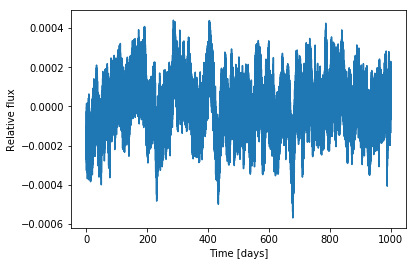

In [10]:
from astropy.constants import M_sun, R_sun, L_sun
import astropy.units as u

sample_times, sample_fluxes, kernel = generate_solar_fluxes(duration=1000*u.day)

sample_fluxes += np.random.normal(loc=0, scale=4e-5, size=len(sample_fluxes))

plt.plot(sample_times.to(u.day).value, sample_fluxes)
plt.xlabel('Time [days]')
plt.ylabel('Relative flux')

Text(0,0.5,'Power [flux$^2$/Hz]')

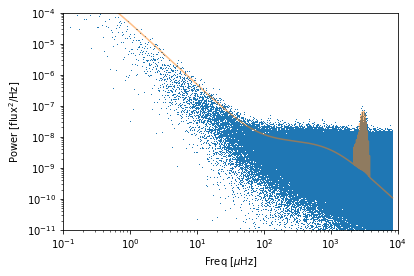

In [11]:
freq, power = power_spectrum(sample_fluxes)

plt.loglog(freq * 1e6, power, ',')
plt.loglog(freq * 1e6, kernel.get_psd(2 * np.pi * freq) / 2 / np.pi, alpha=0.5)
plt.xlim([1e-1, 1e4])
plt.ylim([1e-11, 1e-4])
plt.xlabel('Freq [$\mu$Hz]')
plt.ylabel('Power [flux$^2$/Hz]')

5.02211831210548e-05
4.8820018155737036e-05
4.759259212253808e-05
4.5939045030841864e-05


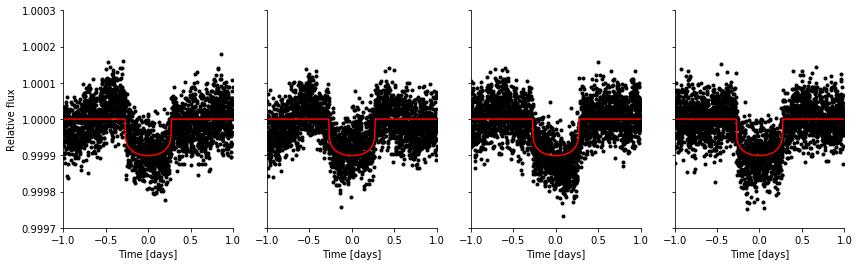

In [245]:
from astropy.constants import M_sun, R_sun, L_sun, R_earth

from batman import TransitModel, TransitParams
params = TransitParams()
params.per = 365.25
params.t0 = 1
params.inc = 90
params.w = 90
params.ecc = 0
params.u = [0.4, 0.2]
params.limb_dark = 'quadratic'
params.a = float(1*u.AU/R_sun)
params.rp = float(R_earth/R_sun)

fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharey=True)
for i in range(4):
#     times, fluxes, kernel = generate_stellar_fluxes(duration=2*u.day, M=1.0 * M_sun, 
#                                                     T_eff=5777 * u.K, 
#                                                     R=1.0 * R_sun, L=L_sun)
    times, fluxes, kernel = generate_solar_fluxes(duration=2*u.day)

    # add white noise
    fluxes += np.random.normal(loc=0, scale=4e-5, size=len(fluxes))
    
    print(fluxes.std())
    
    fluxes += 1
    model = TransitModel(params, times.to(u.day).value)
    lc = model.light_curve(params)

#     ax[i].plot(times.to(u.day).value, fluxes)

    t = times.to(u.day).value - times.to(u.day).value.mean()

    ax[i].scatter(t, lc*fluxes, marker='.', color='k', rasterized=True)
    ax[i].set_ylim([0.9997, 1.0003])
    
    ax[i].plot(t, lc, 'r')
    ax[i].set_xlim([-1, 1])
    
    ax[i].ticklabel_format(useOffset=False)

    ax[i].set_xlabel('Time [days]')
    np.save('simulated_transits/shocksgo_{0:02d}.npy'.format(i), np.vstack([t, lc*fluxes]))

    for s in ['right', 'top']:
        ax[i].spines[s].set_visible(False)
    
ax[0].set_ylabel('Relative flux')
fig.savefig('paper_plots/transits_shocksgo.pdf', bbox_inches='tight')

In [200]:
from astropy.io import fits

data = fits.getdata('../data/VIRGO_1min_0083-7404.fits.gz', cache=False)

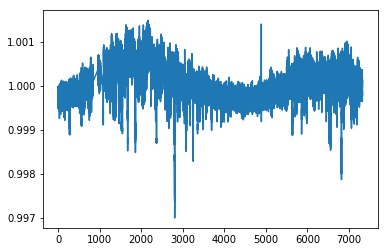

In [14]:
virgo_fluxes = data[data != -99]/np.median(data[data != -99])
virgo_times = np.arange(len(data))[data != -99] / 60 / 24

plt.plot(virgo_times, virgo_fluxes)

In [53]:
np.argmin(np.abs(virgo_times - 4500))

5837838

4.950077759340792e-05
5.137577709923735e-05
6.137814975011272e-05
4.9362822580981784e-05


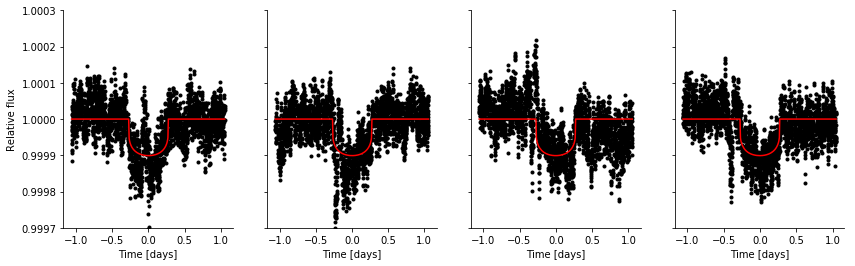

In [237]:
fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharey=True)

one_day = 24 * 60
offset = 0 # 5836000# 6249000  #1000
for i in range(0, 8, 2):
    times = virgo_times[offset+one_day*(i+1) : offset+one_day*(i+3)].copy()
    fluxes = virgo_fluxes[offset+one_day*(i+1) : offset+one_day*(i+3)].copy()
    params.t0 = times.mean()
    fluxes /= np.median(fluxes)
    
    print(fluxes.std())
    model = TransitModel(params, times)
    lc = model.light_curve(params)

    t = times - times.mean()
    ax[i//2].scatter(t, lc*fluxes, marker='.', color='k', rasterized=True)
    ax[i//2].set_ylim([0.9997, 1.0003])
    ax[i//2].plot(t, lc, 'r')
    
    ax[i//2].ticklabel_format(useOffset=False)

    ax[i//2].set_xlabel('Time [days]')

    for s in ['right', 'top']:
        ax[i//2].spines[s].set_visible(False)
    np.save('simulated_transits/virgo_{0:02d}.npy'.format(i//2), np.vstack([t, lc*fluxes]))
ax[0].set_ylabel('Relative flux')
fig.savefig('paper_plots/transits_virgo.pdf', bbox_inches='tight')

# Fit transits

In [238]:
from glob import glob
import emcee
from copy import deepcopy
import batman
import celerite
from celerite import terms, modeling

virgo_transit_times = []
virgo_transit_fluxes = []

paths = glob('simulated_transits/virgo_??.npy')

for i, path in enumerate(paths): 
    t, f = np.load(path)
    t += 365.25 * i
    
    virgo_transit_times.append(t)
    virgo_transit_fluxes.append(f)
    
virgo_transit_times = np.concatenate(virgo_transit_times)
virgo_transit_fluxes = np.concatenate(virgo_transit_fluxes)

# Set up batman+celerite model

def transit_model(p): 
    t0, rp = p[2:]
    trial_params = deepcopy(params)
    trial_params.t0 = t0
    trial_params.rp = rp
    
    m = batman.TransitModel(trial_params, virgo_transit_times)
    return m.light_curve(trial_params)

class MeanModel(modeling.Model):
    parameter_names = ("t0", "rp")
    
    def get_value(self, t):
        trial_params = deepcopy(params)
        trial_params.t0 = self.t0
        trial_params.rp = self.rp
        
        m = batman.TransitModel(trial_params, t)
        return m.light_curve(trial_params)

def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(virgo_transit_fluxes) + lp

kernel = terms.SHOTerm(log_omega0=0, log_S0=0, log_Q=np.log(1/np.sqrt(2)))
kernel.freeze_parameter('log_Q')

mean = MeanModel(t0=0, rp=float(R_earth/R_sun), bounds=dict(t0=(-0.5, 0.5), rp=(0, 1)))
gp = celerite.GP(kernel, mean=mean, fit_mean=True)
gp.compute(virgo_transit_times, 5e-5)

nwalkers, ndim = 20, 4
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=8)

p0 = []
while len(p0) < nwalkers: 
    p = np.array([0, 0, 0, float(R_earth/R_sun)]) + 1e-5*np.random.randn(4)
#     if np.isfinite(lnlike(p)):
    p0.append(p)

p1 = sampler.run_mcmc(p0, 5000)[0]
sampler.reset()
sampler.run_mcmc(p1, 2000)
sampler.pool.close()

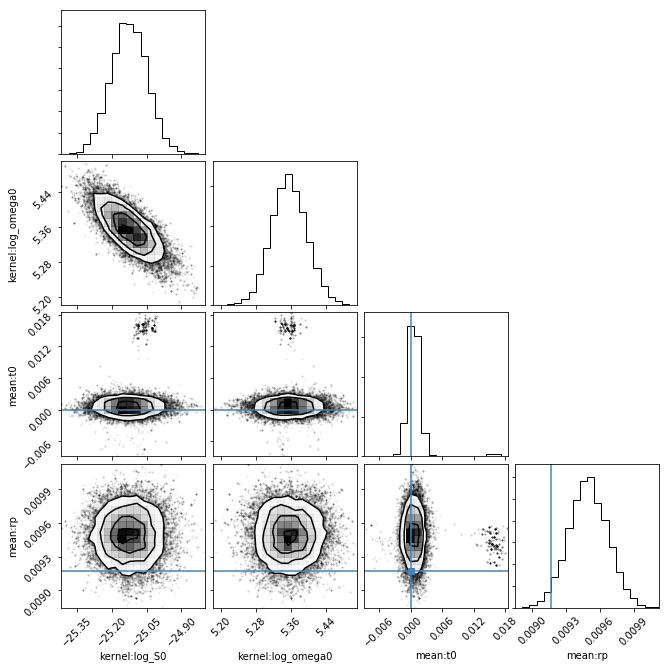

In [239]:
from corner import corner
corner(sampler.flatchain, labels=gp.get_parameter_names(), 
       truths=[None, None, 0, float(R_earth/R_sun)]);

In [240]:
# # Plot the data.
# plt.plot(virgo_transit_times, virgo_transit_fluxes, marker=".", color='k')

# # Plot 24 posterior samples.
# samples = sampler.flatchain
# for s in samples[np.random.randint(len(samples), size=24)]:
#     gp.set_parameter_vector(s)
#     mu = gp.predict(virgo_transit_fluxes, virgo_transit_times, return_cov=False)
#     plt.plot(virgo_transit_times, mu, color='r', alpha=0.1)

# plt.ylabel(r"$y$")
# plt.xlabel(r"$t$")
# plt.xlim(-2, 2)
# plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
# plt.title("posterior predictions");

In [246]:
shocksgo_transit_times = []
shocksgo_transit_fluxes = []

paths = glob('simulated_transits/shocksgo_??.npy')

for i, path in enumerate(paths): 
    t, f = np.load(path)
    t += 365.25 * i
    
    shocksgo_transit_times.append(t)
    shocksgo_transit_fluxes.append(f)
    
shocksgo_transit_times = np.concatenate(shocksgo_transit_times)
shocksgo_transit_fluxes = np.concatenate(shocksgo_transit_fluxes)

def log_probability_shocksgo(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(shocksgo_transit_fluxes) + lp

kernel = terms.SHOTerm(log_omega0=0, log_S0=0, log_Q=np.log(1/np.sqrt(2)))
kernel.freeze_parameter('log_Q')

mean = MeanModel(t0=0, rp=float(R_earth/R_sun), bounds=dict(t0=(-0.01, 0.01), rp=(0, 1)))
gp = celerite.GP(kernel, mean=mean, fit_mean=True)
gp.compute(virgo_transit_times, 5e-5)

nwalkers, ndim = 20, 4
sampler_shocksgo = emcee.EnsembleSampler(nwalkers, ndim, log_probability_shocksgo, threads=8)

p0 = []
while len(p0) < nwalkers: 
    p = np.array([0, 0, 0, float(R_earth/R_sun)]) + 1e-5*np.random.randn(4)
    p0.append(p)

p1 = sampler_shocksgo.run_mcmc(p0, 5000)[0]
sampler_shocksgo.reset()
sampler_shocksgo.run_mcmc(p1, 2000)
sampler_shocksgo.pool.close()

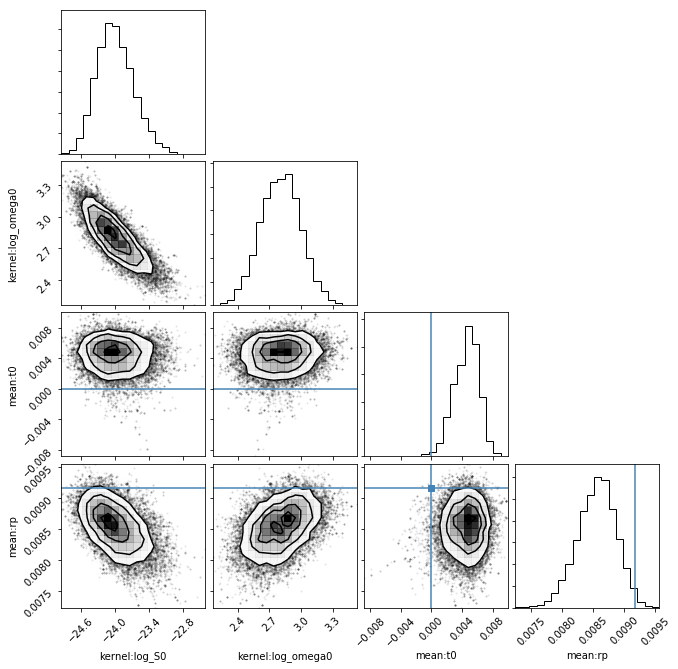

In [247]:
corner(sampler_shocksgo.flatchain, labels=gp.get_parameter_names(), 
       truths=[None, None, 0, float(R_earth/R_sun)]);

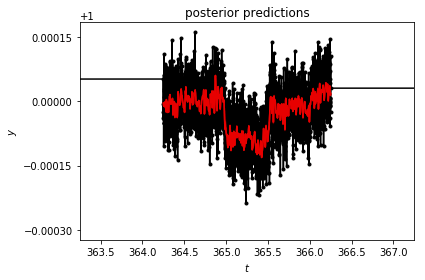

In [243]:
# Plot the data.
plt.plot(shocksgo_transit_times, shocksgo_transit_fluxes, marker=".", color='k')

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(shocksgo_transit_fluxes, virgo_transit_times, return_cov=False)
    plt.plot(shocksgo_transit_times, mu, color='r', alpha=0.1)

plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(-2 + 1*365.25, 2 + 1*365.25)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("posterior predictions");

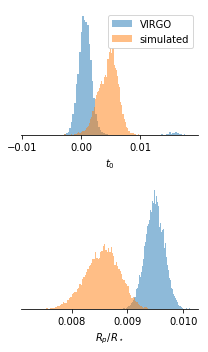

In [253]:
fig, ax = plt.subplots(2, 1, figsize=(3, 5))
ax[0].hist(sampler.flatchain[:, 2], bins=100, histtype='stepfilled', alpha=0.5, label='VIRGO', density=True)
ax[0].hist(sampler_shocksgo.flatchain[:, 2], bins=100, histtype='stepfilled', alpha=0.5, label='simulated', density=True)
ax[0].legend()
ax[0].set_xlabel("$t_0$")

ax[1].hist(sampler.flatchain[:, 3], bins=100, histtype='stepfilled', alpha=0.5, label='VIRGO', density=True)
ax[1].hist(sampler_shocksgo.flatchain[:, 3], bins=100, histtype='stepfilled', alpha=0.5, label='simulated', density=True)
# ax[1].legend()
ax[1].set_xlabel("$R_p/R_\star$")

for axis in ax: 
    for s in ['right', 'top', 'left']:
        axis.set_yticks([])
        axis.spines[s].set_visible(False)
fig.tight_layout()
fig.savefig('paper_plots/posterior_comparison.pdf', bbox_inches='tight')

In [252]:
(1/(0.1*u.uHz)).to(u.day)

<Quantity 115.74074074 d>